# Project 2: Data Representations and Clustering
#### Serena Tang, Liwen Yang, Winston Wang

### Clustering with Sparse Text Representations

*1. Generate sparse TF-IDF representations: Following the steps in Project 1, transform the documents into TF-IDF vectors. Use min df = 3, exclude the stopwords (no need to do stemming or lemmatization), and remove the headers and footers. No need to do any additional data cleaning.*

In [1]:
from sklearn.datasets import fetch_20newsgroups

# get dataset
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
                  'rec.autos', 'rec.motorcycles','rec.sport.baseball', 'rec.sport.hockey']
newsgroups = fetch_20newsgroups(categories=categories, remove=('headers', 'footers'))

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# count vectorizer on corpus
tf_vectorizer = CountVectorizer(min_df = 3, stop_words='english')
newsgroups_vectorized = tf_vectorizer.fit_transform(newsgroups.data)

# count vector to TF-IDF
transformer = TfidfTransformer()
newsgroups_tfidf = transformer.fit_transform(newsgroups_vectorized)

print('Newsgroups TF-IDF Dimensions: ', newsgroups_tfidf.shape)

Newsgroups TF-IDF Dimensions:  (4732, 17131)


### QUESTION 1
- ***Report the dimensions of the TF-IDF matrix you obtain.***
    - The newsgroups TF-IDF matrix had a dimension of (4732, 13477). 

*2. Clustering: Apply K-means clustering with k = 2 using the TF-IDF data. Note that the KMeans class in sklearn has parameters named random state, max iter and n init. Please use `random state=0`, `max iter ≥1000`, and `n_init ≥30`. You can refer to sklearn - Clustering text documents using k-means for a basic work flow.*
- *(a) Given the clustering result and ground truth labels, contingency table A is the matrix whose entries $A_{ij}$ is the number of data points that belong to the i’th class and the j’th cluster.*

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Get clusters
kmeans = KMeans(random_state=0, n_clusters=2, max_iter=1000, n_init=30)
kmeans.fit(newsgroups_tfidf )

KMeans(max_iter=1000, n_clusters=2, n_init=30, random_state=0)

In [4]:
# Map the categories to classes
class_1 = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
class_2=['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
category_to_class=[]
cat_to_num={}
for idx, cat in enumerate(newsgroups.target_names):
    cat_to_num[idx]=cat
for num in newsgroups.target:
    if 'comp.' in cat_to_num[num]:
        category_to_class.append(0)
    else:
        category_to_class.append(1)



<Figure size 640x480 with 0 Axes>

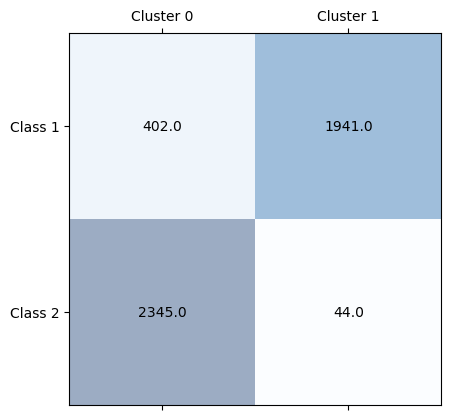

In [5]:
from sklearn import metrics

# plot contingency matrix
fig = plt.figure()
cont_matrix = metrics.cluster.contingency_matrix(category_to_class, kmeans.labels_)
plt.matshow(cont_matrix, cmap=plt.cm.Blues, alpha=0.4)
for (i, j), z in np.ndenumerate(cont_matrix):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.xticks(range(2), ['Cluster 0', 'Cluster 1'])
plt.yticks(range(2), ['Class 1', 'Class 2'])
plt.show()


### QUESTION 2

***Report the contingency table of your clustering result. You may use the provided plotmat.py to visualize the matrix. Does the contingency matrix have to
be square-shaped?***
- The contingency table of the clustering result is shown above. Based on the strong diagonal, we can infer that `Cluster 1` correlates to `Class 1` and `Cluster 0` correlates to `Class 2`. The contingency matrix should be square-shaped as we set the number of clusters in Kmeans to be 2 and our data has 2 classes. If we set the number of clusters in Kmeans to be a different number than the number of classes in the data, the contingency matrix will not be square. 

### Question 3
***Report the 5 clustering measures explained in the introduction for K-means clustering.***

In [6]:
from sklearn.metrics import cluster

# print clustering measures
print("Homogeneity: ", cluster.homogeneity_score(category_to_class, kmeans.labels_))
print("Completeness: ",cluster. completeness_score(category_to_class, kmeans.labels_))
print("V-measure: ", cluster.v_measure_score(category_to_class, kmeans.labels_))
print("Adjusted Rand-Index: ", cluster.adjusted_rand_score(category_to_class, kmeans.labels_))
print("Silhouette Coefficient: ", cluster.silhouette_score(newsgroups_tfidf, kmeans.labels_, sample_size=2000))





Homogeneity:  0.586944967644873
Completeness:  0.5981422594612767
V-measure:  0.5924907147701187
Adjusted Rand-Index:  0.658454925051644
Silhouette Coefficient:  0.0049353313851352824


### Question 4
***Report the plot of the percentage of variance that the top r principle components retain v.s. r, for r = 1 to 1000.***

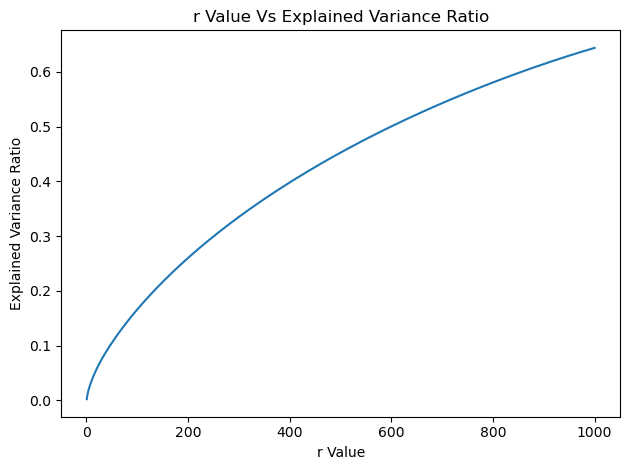

In [7]:
from sklearn.decomposition import TruncatedSVD

# get principle components
svd_1000 = TruncatedSVD(n_components=1000, random_state=0)
newsgroups_lsi = svd_1000.fit_transform(newsgroups_tfidf)

# get explained variance ratio
x = list(range(1, 1001))
ratio = svd_1000.explained_variance_ratio_
ex_var = np.cumsum(ratio)

# plot explained variance ratio
plt.plot(x, ex_var)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('r Value')
plt.title('r Value Vs Explained Variance Ratio')
plt.tight_layout()

### Question 5
***Let r be the dimension that we want to reduce the data to (i.e. n components). Try r = 1−10, 20, 50, 100, 300, and plot the 5 measure scores v.s. r for both SVD
and NMF. Report a good choice of r for SVD and NMF respectively. Note: In the choice of r, there is a trade-off between the information preservation, and better performance of
k-means in lower dimensions.***
- The plots are shown below. Based on the results, r=50 is a good choice for SVD and r=2 is a good choise for NMF.

In [8]:
from sklearn.decomposition import NMF

r = [1,2,3,4,5,6,7,8,9,10,20,50,100,300]

def SVD_score(r,X,y):
    adj_rand_score=[]
    sil_score=[]
    hom_score=[]
    comp_score=[]
    v_score=[]
    for dim in r:
        svd=TruncatedSVD(n_components = dim, random_state=0)
        trunc_svd=svd.fit_transform(X)
        kmeans = KMeans(random_state=0, n_clusters=2, max_iter=1000, n_init=30)
        kmeans.fit(trunc_svd)

        adj_rand_score.append(cluster.adjusted_rand_score(y,kmeans.labels_))
        sil_score.append(cluster.silhouette_score(X, kmeans.labels_, sample_size=2000))
        hom_score.append(cluster.homogeneity_score(y,kmeans.labels_))
        comp_score.append(cluster.completeness_score(y,kmeans.labels_))
        v_score.append(cluster.v_measure_score(y,kmeans.labels_))
    return adj_rand_score, sil_score, hom_score, comp_score, v_score

def NMF_score(r,X,y):
    adj_rand_score=[]
    sil_score=[]
    hom_score=[]
    comp_score=[]
    v_score=[]
    for dim in r:
        nmf = NMF(n_components = dim, init='random', random_state=0, max_iter=500)
        trunc_nmf=nmf.fit_transform(X)
        kmeans = KMeans(random_state=0, n_clusters=2, max_iter=1000, n_init=30)
        kmeans.fit(trunc_nmf)

        adj_rand_score.append(cluster.adjusted_rand_score(y,kmeans.labels_))
        sil_score.append(cluster.silhouette_score(X, kmeans.labels_, sample_size=2000))
        hom_score.append(cluster.homogeneity_score(y,kmeans.labels_))
        comp_score.append(cluster.completeness_score(y,kmeans.labels_))
        v_score.append(cluster.v_measure_score(y,kmeans.labels_))
    return adj_rand_score, sil_score, hom_score, comp_score, v_score

In [9]:
svd_adj_rand_score, svd_sil_score, svd_hom_score, svd_comp_score, svd_v_score= SVD_score(r,newsgroups_tfidf, category_to_class)
nmf_adj_rand_score, nmf_sil_score, nmf_hom_score, nmf_comp_score, nmf_v_score= NMF_score(r,newsgroups_tfidf, category_to_class)

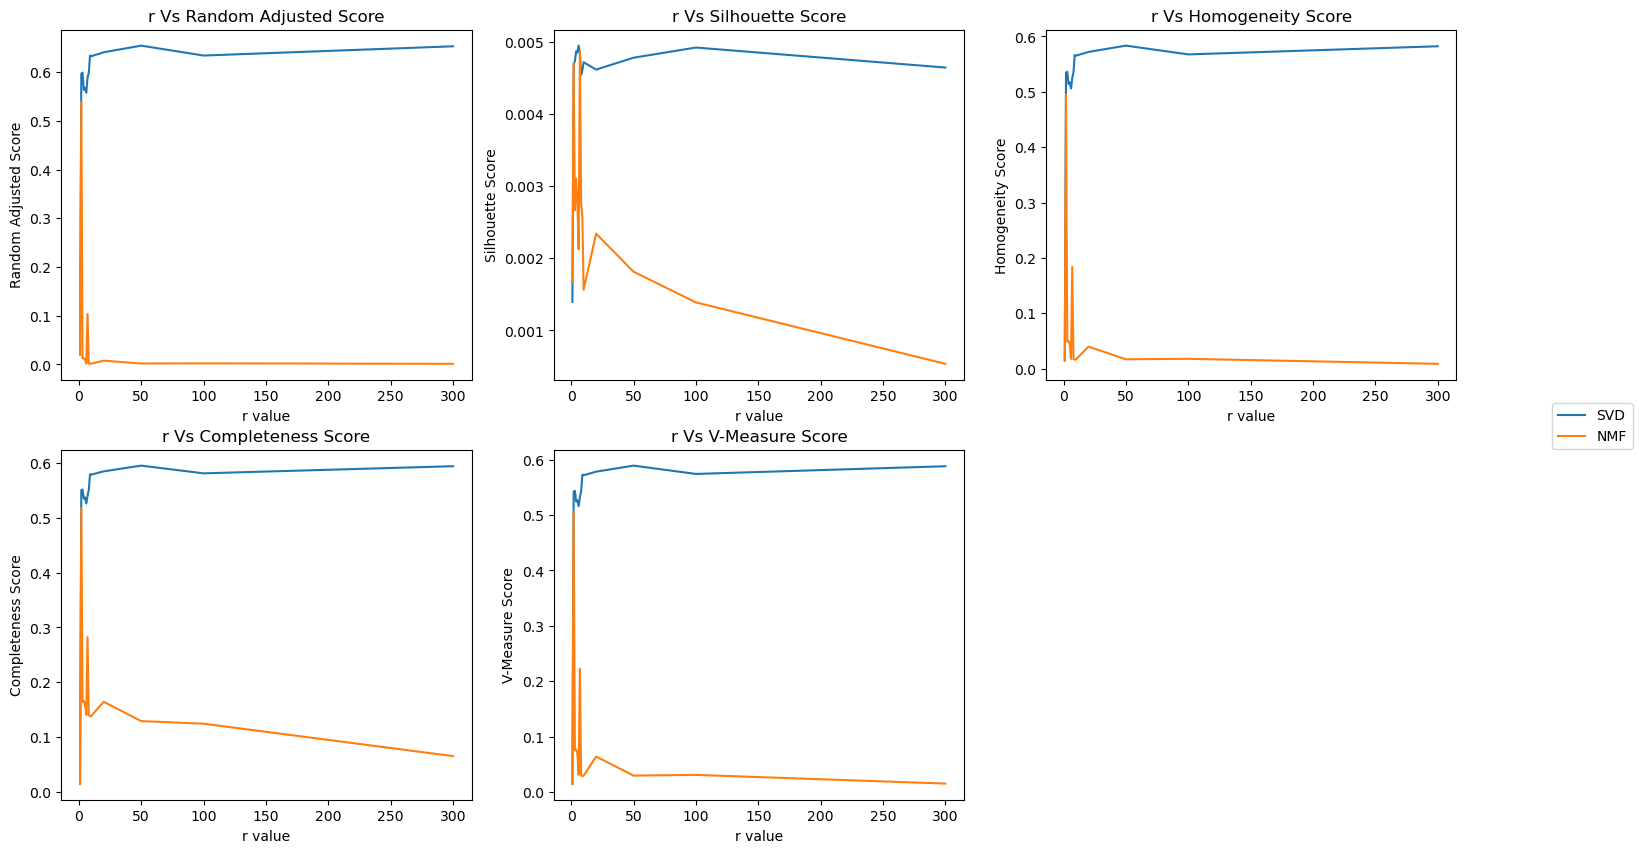

In [10]:
fig = plt.figure(figsize=(18, 10))
axes = fig.subplots(nrows=2, ncols=3)

axes[0, 0].plot(r,svd_adj_rand_score, label='SVD')
axes[0, 0].plot(r,nmf_adj_rand_score, label='NMF')
axes[0, 0].title.set_text('r Vs Random Adjusted Score')
axes[0, 0].set_xlabel('r value')
axes[0, 0].set_ylabel('Random Adjusted Score')

axes[0, 1].plot(r,svd_sil_score, label='SVD')
axes[0, 1].plot(r,nmf_sil_score, label='NMF')
axes[0, 1].title.set_text('r Vs Silhouette Score')
axes[0, 1].set_xlabel('r value')
axes[0, 1].set_ylabel('Silhouette Score')

axes[0, 2].plot(r,svd_hom_score, label='SVD')
axes[0, 2].plot(r,nmf_hom_score, label='NMF')
axes[0, 2].title.set_text('r Vs Homogeneity Score')
axes[0, 2].set_xlabel('r value')
axes[0, 2].set_ylabel('Homogeneity Score')

axes[1, 0].plot(r,svd_comp_score, label='SVD')
axes[1, 0].plot(r,nmf_comp_score, label='NMF')
axes[1, 0].title.set_text('r Vs Completeness Score')
axes[1, 0].set_xlabel('r value')
axes[1, 0].set_ylabel('Completeness Score')

axes[1, 1].plot(r,svd_v_score, label='SVD')
axes[1, 1].plot(r,nmf_v_score, label='NMF')
axes[1, 1].title.set_text('r Vs V-Measure Score')
axes[1, 1].set_xlabel('r value')
axes[1, 1].set_ylabel('V-Measure Score')

axes[1, 2].axis('off')

fig.legend(['SVD','NMF'], loc='center right')

plt.show()


In [11]:
import statistics
from statistics import mode

svd_score=[svd_adj_rand_score, svd_sil_score, svd_hom_score, svd_comp_score, svd_v_score]
argmaxes=[]
for i in svd_score:
    argmaxes.append(i.index(max(i)))
svd_bestr_ind=round(mode(argmaxes))
print('Best SVD r value: ',r[svd_bestr_ind])

nmf_score=[nmf_adj_rand_score, nmf_sil_score, nmf_hom_score, nmf_comp_score, nmf_v_score]
argmaxes=[]
for i in nmf_score:
    argmaxes.append(i.index(max(i)))
nmf_bestr_ind=round(mode(argmaxes))
print('Best NMF r value: ',r[nmf_bestr_ind])

Best SVD r value:  50
Best NMF r value:  2


### Question 6

***How do you explain the non-monotonic behavior of the measures as r increases?***

While dimensionality reduction can help us work with noisy data and to reduce algorithm run time, it may also cause the data to lose information such as noise. So as r initially increases, our Kmeans clusters may be inaccurate as we truncated too much of the data; however, as r increases, we may see the scores begin to increase and then decrease. This initial increase implies we have a good trade off between the scores and how much of the data was truncated. The eventual decrease can imply that as our truncated data gets larger, more noise is being introduced; this can lead to an inaccurate clustering by Kmeans and the decreased score. Therefore, due to this, we can see the non-monotonic behaviour of the measures as r increases. 

### QUESTION 7

***Are these measures on average better than those computed in Question 3?***
- The average measures for the SVD and NMF metrics are shown below. Both performed worse than those computed in Question 3; however, the SVD metrics are a lot closer to those computed in Question 3 than using the NMF. 

In [12]:
print("SVD Metrics (r=50): ")
print("Homogeneity: ", np.mean(svd_hom_score))
print("Completeness: ",np.mean(svd_comp_score))
print("V-measure: ", np.mean(svd_v_score))
print("Adjusted Rand-Index: ", np.mean(svd_adj_rand_score))
print("Silhouette Coefficient: ", np.mean(svd_sil_score))


print("\nNMF Metrics (r=2): ")
print("Homogeneity: ", np.mean(nmf_hom_score))
print("Completeness: ",np.mean(nmf_comp_score))
print("V-measure: ", np.mean(nmf_v_score))
print("Adjusted Rand-Index: ", np.mean(nmf_adj_rand_score))
print("Silhouette Coefficient: ", np.mean(nmf_sil_score))



SVD Metrics (r=50): 
Homogeneity:  0.5086295760481007
Completeness:  0.5226573391383235
V-measure:  0.515542491271773
Adjusted Rand-Index:  0.567182526171996
Silhouette Coefficient:  0.004507834808964868

NMF Metrics (r=2): 
Homogeneity:  0.0704770686887141
Completeness:  0.16756615651774417
V-measure:  0.08748731407893089
Adjusted Rand-Index:  0.051330192251747724
Silhouette Coefficient:  0.002490472396149145


### QUESTION 8
***Visualize the clustering results for:***
- ***SVD with your optimal choice of r for K-Means clustering***
- ***NMF with your choice of r for K-Means clustering.***

The clustering results are shown below.

In [13]:
svd_50 = TruncatedSVD(n_components=50, random_state=0)
trunc_svd = svd_50.fit_transform(newsgroups_tfidf)

nmf_2 = NMF(n_components=2, random_state=0, init='random', max_iter=500)
trunc_nmf = nmf_2.fit_transform(newsgroups_tfidf)

fig = plt.figure(figsize=(18, 10))
axes = fig.subplots(nrows=2, ncols=2)

kmeans.fit(trunc_svd)

axes[0, 0].scatter(trunc_svd[:,0], trunc_svd[:,1],c=kmeans.labels_, cmap=plt.cm.winter)
axes[0, 0].title.set_text('SVD: Clustering Label')

axes[0, 1].scatter(trunc_svd[:,0], trunc_svd[:,1],c=category_to_class, cmap=plt.cm.winter)
axes[0, 1].title.set_text('SVD: Ground Truth Label')

kmeans.fit(trunc_nmf)

axes[1, 0].scatter(trunc_nmf[:,0], trunc_nmf[:,1],c=kmeans.labels_, cmap=plt.cm.summer)
axes[1, 0].title.set_text('NMF: Clustering Label')

axes[1, 1].scatter(trunc_nmf[:,0], trunc_nmf[:,1],c=category_to_class, cmap=plt.cm.summer)
axes[1, 1].title.set_text('NMF: Ground Truth Label')

### QUESTION 9
***What do you observe in the visualization? How are the data points of the two classes distributed? Is distribution of the data ideal for K-Means clustering?***
- Based on the plots above, it appears that the labels for clustering and the groung truth are generally very similar; however, the ground truth labels imply that there is a good amount of overlap between the labels. This is not shown in the clustering label plot for NMF and SVD as there is a more clear cut line between the two labels. The data does not have a spherical distribution and are instead distributed in more of a triangular shape with centroids for each label close to each other. There are also a few outliers that are farther away from the main cluster. Since K-Means clustering assumes that there is a spherical distribution, the data distribution is not ideal. 

### QUESTION 10

***Load documents with the same configuration as in Question 1, but for ALL 20 categories. Construct the TF-IDF matrix, reduce its dimensionality using BOTH NMF and SVD (specify settings you choose and why), and perform K-Means clustering with k=20. Visualize the contingency matrix and report the five clustering metrics (DO BOTH NMF AND SVD).***

In [1]:
# load data
newsgroups = fetch_20newsgroups(remove=('headers', 'footers'))

# count vectorizer on corpus
tf_vectorizer = CountVectorizer(min_df = 3, stop_words='english')
newsgroups_vectorized = tf_vectorizer.fit_transform(newsgroups.data)

# count vector to TF-IDF
transformer = TfidfTransformer()
newsgroups_tfidf = transformer.fit_transform(newsgroups_vectorized)

kmeans = KMeans(random_state=0, n_clusters=20, max_iter=1000, n_init=30)

NameError: name 'fetch_20newsgroups' is not defined

In [96]:
# search for best r value for SVD
r = [1,2,3,4,5,6,7,8,9,10,20,50,100,300]
svd_adj_rand_score, svd_sil_score, svd_hom_score, svd_comp_score, svd_v_score = SVD_score(r,newsgroups_tfidf, newsgroups.target)

svd_score=[svd_adj_rand_score, svd_sil_score, svd_hom_score, svd_comp_score, svd_v_score]
argmaxes=[]
for i in svd_score:
    argmaxes.append(i.index(max(i)))
svd_bestr_ind=round(mode(argmaxes))
print('Best SVD r value: ',r[svd_bestr_ind])




In [ ]:
svd_bestr = TruncatedSVD(n_components=r[svd_bestr_ind], random_state=0)
trunc_svd = svd_bestr.fit_transform(newsgroups_tfidf)
kmeans.fit(trunc_svd)

# print clustering measures
print("Homogeneity: ", cluster.homogeneity_score(newsgroups.target, kmeans.labels_))
print("Completeness: ",cluster. completeness_score(newsgroups.target, kmeans.labels_))
print("V-measure: ", cluster.v_measure_score(newsgroups.target, kmeans.labels_))
print("Adjusted Rand-Index: ", cluster.adjusted_rand_score(newsgroups.target, kmeans.labels_))
print("Silhouette Coefficient: ", cluster.silhouette_score(newsgroups_tfidf, kmeans.labels_, sample_size=2000))

In [ ]:
from plotmat import plot_mat # using the provided plotmat.py
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(newsgroups.target, kmeans.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols,yticklabels=rows, size=(15,15))

In [ ]:
# search for best r value for NMF
r = [1,2,3,4,5,6,7,8,9,10,20,50,100,300]
nmf_adj_rand_score, nmf_sil_score, nmf_hom_score, nmf_comp_score, nmf_v_score= NMF_score(r,newsgroups_tfidf, newsgroups.target)

nmf_score=[nmf_adj_rand_score, nmf_sil_score, nmf_hom_score, nmf_comp_score, nmf_v_score]
argmaxes=[]
for i in nmf_score:
    argmaxes.append(i.index(max(i)))
nmf_bestr_ind=round(mode(argmaxes))
print('Best NMF r value: ',r[nmf_bestr_ind])


In [ ]:
nmf_bestr = NMF(n_components=r[nmf_bestr_ind], random_state=0, init='random', max_iter=500)
trunc_nmf = nmf_bestr.fit_transform(newsgroups_tfidf)
kmeans.fit(trunc_nmf)

# print clustering measures
print("Homogeneity: ", cluster.homogeneity_score(newsgroups.target, kmeans.labels_))
print("Completeness: ",cluster. completeness_score(newsgroups.target, kmeans.labels_))
print("V-measure: ", cluster.v_measure_score(newsgroups.target, kmeans.labels_))
print("Adjusted Rand-Index: ", cluster.adjusted_rand_score(newsgroups.target, kmeans.labels_))
print("Silhouette Coefficient: ", cluster.silhouette_score(newsgroups_tfidf, kmeans.labels_, sample_size=2000))

In [ ]:
cm = confusion_matrix(newsgroups.target, kmeans.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols,yticklabels=rows, size=(15,15))